<a href="https://colab.research.google.com/github/ghadaFerjani97/Jeu_casino/blob/master/OSS_ventures_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **First approach**

The core of our solution is an autoencoder, which is basically an encoder-decoder system to reconstruct the input as the output. Our goal is to train a convolutional autoencoder so that it will reconstruct an image from the normal data with a smaller reconstruction error, but reconstruct an image from the anomaly data with a larger reconstruction error . Our solution will show us that the reconstruction error is hight when we have an anomalous input and is low when we have an anomalous free input. After that we will only consider the encoding part for a multiclass classification. 
 The evaluation criteria for this task is the accuracy of identifying the class of the anomaly . 

## **Imports**

In [ ]:
import os
import keras
from keras.models import Sequential,Model
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from PIL import Image, ImageChops
import random
import cv2 
from keras.layers.normalization import BatchNormalization
import glob
from keras.preprocessing.image import *
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import warnings, glob
#Filter Warnings
warnings.simplefilter("ignore")
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

import skimage.io
import numpy as np
import skimage.transform
from skimage import img_as_float,exposure, util,img_as_ubyte,feature
import itertools

import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import * 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import *

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


Using TensorFlow backend.


# **Load images**

In [ ]:
path_non_anomalous="./Dataset/ok_parts"
path_all_anomalous="./Dataset/damaged"

## **Data augmentation**

In [ ]:
#parameters 

batch_size=3

#Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
# Create generators for training, validation and testing
# target size = (300,300), initially images where of size (700,700). We compress the images to reduce the cost of storing or performing operations on them , to keep the most significant components of the image and to discard the rest

train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)


train_generator = train_datagen.flow_from_directory(
    directory=path_non_anomalous,
    target_size=(300, 300),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode = "input",
    subset='training',
    shuffle=True,
    seed=42
)
test_generator = train_datagen.flow_from_directory(
    directory=path_non_anomalous,
    target_size=(300, 300),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode = "input", 
    subset='validation',
    shuffle=True,
    seed=42
)

test_datagen = ImageDataGenerator(data_format='channels_last')
anomaly_generator = test_datagen.flow_from_directory(
    path_all_anomalous,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='input'
    )

Found 176 images belonging to 1 classes.
Found 44 images belonging to 1 classes.
Found 115 images belonging to 5 classes.


# **Building the Autoencoder**

In [ ]:
def build_model():
        input_layer = Input(shape=(300,300,3))
        
        # encoder
        h = Conv2D(64, (5, 5), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)

        # Bottle neck
        h = Conv2D(16, (1, 1), activation='relu', padding='valid')(h)

        # decoder
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Conv2D(64, (5, 5), activation='relu', padding='same')(h)
        output_layer = Conv2D(3, (3, 3), activation='linear', padding='same')(h)
        
        model= Model(input_layer, output_layer)
        model.compile(optimizer='adam', loss='mse')
        model.summary()
        return model

In [ ]:
model=build_model()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 300, 300, 64)      4864      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_363 (Conv2D)          (None, 75, 75, 16)      

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=20,
        validation_data=test_generator,
        validation_steps=3)

Epoch 1/20
10/10 [==============================] - 1s 123ms/step - loss: 2005.3879 - val_loss: 412.1310
Epoch 2/20
10/10 [==============================] - 1s 106ms/step - loss: 487.0327 - val_loss: 292.1995
Epoch 3/20
10/10 [==============================] - 1s 106ms/step - loss: 310.4434 - val_loss: 233.0123
Epoch 4/20
10/10 [==============================] - 1s 103ms/step - loss: 245.8216 - val_loss: 200.0057
Epoch 5/20
10/10 [==============================] - 1s 106ms/step - loss: 201.4077 - val_loss: 165.4830
Epoch 6/20
10/10 [==============================] - 1s 107ms/step - loss: 161.5737 - val_loss: 133.1742
Epoch 7/20
10/10 [==============================] - 1s 108ms/step - loss: 139.1973 - val_loss: 120.9546
Epoch 8/20
10/10 [==============================] - 1s 108ms/step - loss: 121.0541 - val_loss: 106.5335
Epoch 9/20
10/10 [==============================] - 1s 108ms/step - loss: 113.0301 - val_loss: 98.7663
Epoch 10/20
10/10 [==============================] - 1s 108ms/st

# **Evaluating the model**

In [ ]:
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
predicted = np.ceil(predicted).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


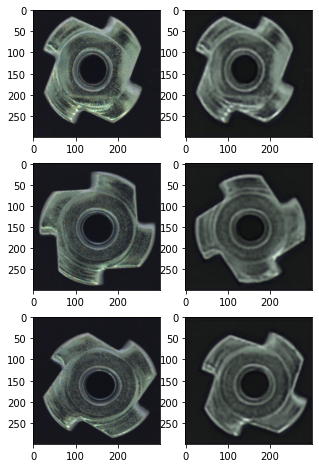

In [ ]:
#plotting 4 samples to evaluate the model 
no_of_samples = 3
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(np.ceil(data_list[i][i]).astype(int))
    print()
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
# We want the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(test_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

Error on validation set:55.250709533691406, error on anomaly set:70.70757293701172


## **Classification based on the encoder**

In [ ]:
input_layer = Input(shape=(300,300,3))
for cpt, layer in enumerate(model.layers):
    if(cpt > 0 and cpt < 6):
      layer.trainable = False
      if(cpt == 1): 
        x = layer(input_layer)
      else:
        x = layer(x)

x = Flatten()(x)
model_encoder = Model(input_layer, x)
model_encoder.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 300, 300, 64)      4864      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 75, 75, 32)        9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 180000)          

***Get all images for classification***

In [ ]:
all_class_data = glob.glob( './Dataset/damaged/*/*.png')

**Getting the bottle neck of the autoencoder for all images**

In [ ]:
#images encoded 
img_encoding_class = []
for image_path in all_class_data:
  class_img = image_path.split("/")[-2]
  image =  load_img(image_path,target_size=(300, 300))
  input_arr = img_to_array(image)
  embedding = model_encoder.predict(np.expand_dims(input_arr,0))[0]
  img_encoding_class.append([embedding,class_img])
img_encoding_class = np.array(img_encoding_class)


**Doing ACP to reduce the dimmensionnality of the encoded images before classification**

In [ ]:
from sklearn.decomposition import PCA

data_reduced = np.array([elt for elt in img_encoding_class[:,0]])
pca = PCA(n_components=10,random_state=42)
data_reduced = pca.fit_transform(data_reduced)


In [ ]:
print(pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())

[0.21280116 0.20134886 0.0844015  0.07867414 0.06646699 0.03048769
 0.02799029 0.02492432 0.01938847 0.01637029] 0.76285374


**Splitting data into train and test**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_reduced, img_encoding_class[:,1],test_size=0.2, stratify=img_encoding_class[:,1], random_state=42)

In [ ]:
from sklearn import svm

clf = svm.SVC(C=17.5,random_state=42,kernel='poly')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
target_names = np.unique(y_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        bent       0.60      0.60      0.60         5
       color       1.00      0.25      0.40         4
        flip       1.00      1.00      1.00         5
        good       0.60      0.75      0.67         4
     scratch       0.57      0.80      0.67         5

    accuracy                           0.70        23
   macro avg       0.75      0.68      0.67        23
weighted avg       0.75      0.70      0.68        23



**Second approach**

We will be Creating combination between images. Classification will be done by learning distances between classes.
Explaining the idea:
We split the folder damaged into train and test sets.
From the train set (78 images), we establish all the possible combinations (Image i , Image j ) for i and j running through the 78 images.
We build a new dataset where the new images are of the form Image i - Image j , the label of this subtraction is either same or different. 
Same if image i and image j belong to the same class, different otherwise.
We train our CNN to learn this binary classification ( supervised problem)

For the test set, we subtract each image from the 78 reference images of train. 
We do the classification of each substraction , either same or difference.
With a majoritary vote, we decide the class of the image






In [ ]:
data_imgs = glob.glob("./Dataset/damaged/*/*.png")
data_imgs = data_imgs
classification_data = pd.DataFrame(data_imgs,columns=["img_path"])
classification_data["class_anomaly"] = classification_data["img_path"].apply(lambda x : x.split("/")[-2])
classification_data = classification_data.sample(frac=1,random_state=42) #ramdomizing image's order
classification_data.head()

,img_path,class_anomaly
81,./Dataset/damaged/bent/008.png,bent
4,./Dataset/damaged/scratch/014.png,scratch
40,./Dataset/damaged/flip/007.png,flip
69,./Dataset/damaged/bent/021.png,bent
10,./Dataset/damaged/scratch/013.png,scratch


(700, 700, 3)


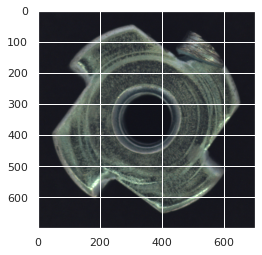

In [ ]:
img = skimage.io.imread(classification_data["img_path"].values[0])
print(img.shape)
plt.imshow(img)

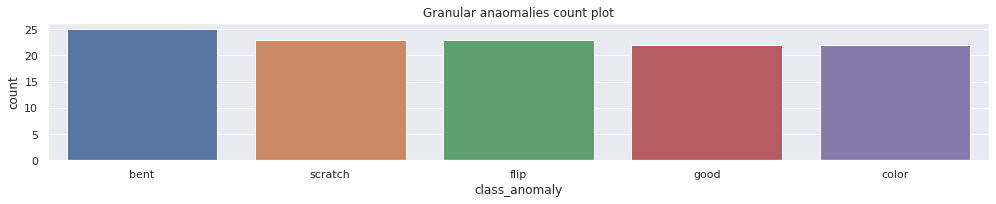

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 3))
sns.countplot(x="class_anomaly", data=classification_data, ax=axes)
axes.set_title("Granular anaomalies count plot")
plt.tight_layout()
plt.show()

**Data preparation**

Isolating some images for test purposes


In [ ]:
meta_x_train, meta_x_test, meta_y_train, meta_y_test = train_test_split(classification_data["img_path"], classification_data["class_anomaly"],test_size=0.20, stratify=classification_data["class_anomaly"], random_state=42)
meta_df_train = pd.DataFrame(np.column_stack((meta_x_train,meta_y_train)),columns=["img_path","class"])
meta_df_test = pd.DataFrame(np.column_stack((meta_x_test,meta_y_test)),columns=["img_path","class"])
print(meta_x_train.shape, meta_x_test.shape)

(92,) (23,)


In [ ]:
combiantion_img_indeces = (list(itertools.combinations(meta_df_train.index,2)))
distance_data = []
for (index_img_1, index_img_2) in combiantion_img_indeces:
    img_path_1, img_class_1 = meta_df_train.loc[index_img_1]["img_path"], meta_df_train.loc[index_img_1]["class"]
    img_path_2, img_class_2 = meta_df_train.loc[index_img_2]["img_path"], meta_df_train.loc[index_img_2]["class"]
    class_distance = 'same' if(img_class_2 == img_class_1) else 'different'
    distance_data.append([img_path_1,img_path_2, class_distance])

distance_data = np.array(distance_data)
df_distance_problem = pd.DataFrame(distance_data,columns=["img_path_1", "img_path_2", "class_distance"])
df_distance_problem.head()

,img_path_1,img_path_2,class_distance
0,./Dataset/damaged/scratch/019.png,./Dataset/damaged/color/002.png,different
1,./Dataset/damaged/scratch/019.png,./Dataset/damaged/scratch/003.png,same
2,./Dataset/damaged/scratch/019.png,./Dataset/damaged/scratch/012.png,same
3,./Dataset/damaged/scratch/019.png,./Dataset/damaged/bent/022.png,different
4,./Dataset/damaged/scratch/019.png,./Dataset/damaged/color/013.png,different


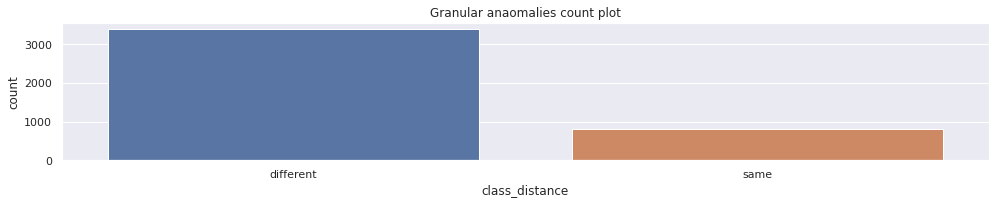

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 3))
sns.countplot(x="class_distance", data=df_distance_problem, ax=axes)
axes.set_title("Granular anaomalies count plot")
plt.tight_layout()
plt.show()

In [ ]:
#nb_classes
nb_classes = df_distance_problem["class_distance"].nunique()

lb_classification = MultiLabelBinarizer()
labels_encoded = lb_classification.fit_transform(df_distance_problem[["class_distance"]].values)

x_train, x_test, y_train, y_test = train_test_split(df_distance_problem[["img_path_1","img_path_2"]].values, labels_encoded,test_size=0.20, stratify=labels_encoded, random_state=42)

class_weights = compute_class_weight('balanced', np.unique(df_distance_problem["class_distance"]), df_distance_problem["class_distance"])
balanced_class_weights = dict(enumerate(class_weights))
print(x_train.shape, x_test.shape, nb_classes, balanced_class_weights)

(3348, 2) (838, 2) 2 {0: 0.6184988179669031, 1: 2.609725685785536}


**Helpers**

In [ ]:
#Reproductibility
seed_value= 1
random.seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = str(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



def plot_history(history_dict,nb_epochs):
    
    metrics = list(history_dict.keys())
    plt.style.use("ggplot")
    fig, axs = plt.subplots(1,len(metrics)//2, figsize=(5*len(metrics)//2,5))
    fig.suptitle('Training/Test performences')
    range_epochs = range(1,nb_epochs+1)
    axis_iter = 0
    for metric in metrics[:len(metrics)//2] :
        axs[axis_iter].plot(range_epochs,history_dict[metric] , label="train_"+metric)
        axs[axis_iter].plot(range_epochs, history_dict["val_"+metric], label="test_"+metric)
        axs[axis_iter].set_xlabel("Epoch #")
        axs[axis_iter].set_xlabel(metric)
        axs[axis_iter].legend(loc="best")
        axis_iter+=1
    plt.show()
    
class data_augmentor():

    def random_rotation(self, img):
        # pick a random degree of rotation between 25% on the left and 25% on the right
        random_degree = random.uniform(-25, 25)
        return skimage.transform.rotate(img, random_degree)
    
    def random_noise(self, img):
        # add random noise to the image
        return util.random_noise(img)

    def horizontal_flip(self, img):
        # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
        return img[:, ::-1]

    def data_augment(self, img, nb_transformation):


        available_transformations = {
            'rotate': self.random_rotation,
            'noise': self.random_noise,
            'horizontal_flip': self.horizontal_flip
            
        }

        # find all files paths from the folder
        num_transformations = 1
        transformed_images = [img]
        while num_transformations <= nb_transformation:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](img)
            transformed_images.append(transformed_image)
            num_transformations += 1

        gamma_corrected = exposure.adjust_gamma(img, 2)
        transformed_images.append(gamma_corrected)
        # Logarithmic
        logarithmic_corrected = exposure.adjust_log(img, 1)
        transformed_images.append(logarithmic_corrected)

        return transformed_images


class batch_generator(keras.utils.Sequence) :
  
    def __init__(self, tuple_image_paths, labels, batch_size, use_data_aug=False) :
        
        self.tuple_image_paths = tuple_image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.data_augmentor = data_augmentor()
        self.use_data_aug = use_data_aug
        
    def __len__(self) :
        return (np.ceil(len(self.tuple_image_paths) / float(self.batch_size))).astype(np.int)

      
    def __getitem__(self, idx) :
        
        #Generating batch data
        batch_x = self.tuple_image_paths[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        preprocessed_augmented_batch_images = []
        augmented_batch_labels = []
        for [path_1,path_2] in batch_x:
            img_keras_1 = load_img(path_1,target_size=(350,350))
            img_keras_1 = img_to_array(img_keras_1)/255
            img_keras_2 = load_img(path_2,target_size=(350,350))
            img_keras_2 = img_to_array(img_keras_2)/255
            
            img_keras_to_feed = np.absolute(img_keras_1-img_keras_2)
            preprocessed_augmented_batch_images.append(img_keras_to_feed)
            
        preprocessed_augmented_batch_images = np.array(preprocessed_augmented_batch_images, dtype="float32")
        augmented_batch_labels = np.array(batch_y_labels)
        return preprocessed_augmented_batch_images, augmented_batch_labels

**building the model**

In [ ]:
def create_model(nb_classes):
    
    initializer = tf.keras.initializers.GlorotNormal(seed=42)
    
    input_img = Input(shape = (350, 350, 3))
    conv_layer_1 = Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=initializer )(input_img)
    max_pool_1 = MaxPooling2D((2,2),padding='same')(conv_layer_1)
    conv_layer_2 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=initializer)(max_pool_1)
    max_pool_2 = MaxPooling2D((2,2),padding='same')(conv_layer_2)
    conv_layer_3 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=initializer)(max_pool_2)
    max_pool_3 = MaxPooling2D((2,2),padding='same')(conv_layer_3)
    conv_layer_4 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=initializer)(max_pool_3)
    max_pool_4 = MaxPooling2D((2,2),padding='same')(conv_layer_4)
    conv_layer_5 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=initializer)(max_pool_4)
    max_pool_5 = MaxPooling2D((2,2),padding='same')(conv_layer_5)
    flatten_layer = Flatten()(max_pool_5)
    dense_layer_2 = Dense(256, activation='relu', kernel_initializer=initializer)(flatten_layer)
    dropout_layer_1 = Dropout(0.5)(dense_layer_2)
    dense_layer_1 = Dense(64, activation='relu', kernel_initializer=initializer)(dropout_layer_1)
    final_layer = Dense(nb_classes, activation='softmax')(dense_layer_1)
    
    model = Model(inputs=input_img, outputs=final_layer)
    
    opt = SGD(learning_rate=1e-2, momentum=0.9, nesterov=True, name="SGD")
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


In [ ]:
classification_model = create_model(nb_classes)
classification_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 350, 350, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 350, 350, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 175, 175, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 175, 175, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 88, 88, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 44, 32)       

In [ ]:
classification_batch_size = 50
classification_update_steps = 30
classification_epochs = 25

my_training_batch_generator = batch_generator(x_train,y_train, classification_batch_size)
my_validation_batch_generator = batch_generator(x_test,y_test, classification_batch_size)

In [ ]:
classification_history = classification_model.fit_generator(my_training_batch_generator,
                steps_per_epoch = classification_update_steps,
                epochs = classification_epochs,
                verbose = 1,
                validation_data = my_validation_batch_generator,
                class_weight=balanced_class_weights)

Epoch 1/25
30/30 [==============================] - 63s 2s/step - loss: 0.6995 - accuracy: 0.3540 - val_loss: 0.6674 - val_accuracy: 0.8079
Epoch 2/25
30/30 [==============================] - 62s 2s/step - loss: 0.6839 - accuracy: 0.7183 - val_loss: 0.6589 - val_accuracy: 0.8079
Epoch 3/25
30/30 [==============================] - 62s 2s/step - loss: 0.6855 - accuracy: 0.5347 - val_loss: 0.5856 - val_accuracy: 0.8079
Epoch 4/25
30/30 [==============================] - 62s 2s/step - loss: 0.6687 - accuracy: 0.6107 - val_loss: 0.6386 - val_accuracy: 0.5835
Epoch 5/25
30/30 [==============================] - 62s 2s/step - loss: 0.6383 - accuracy: 0.5933 - val_loss: 0.6740 - val_accuracy: 0.5060
Epoch 6/25
30/30 [==============================] - 62s 2s/step - loss: 0.6159 - accuracy: 0.6202 - val_loss: 0.6290 - val_accuracy: 0.5179
Epoch 7/25
30/30 [==============================] - 63s 2s/step - loss: 0.6372 - accuracy: 0.5407 - val_loss: 0.5654 - val_accuracy: 0.5907
Epoch 8/25
30/30 [==

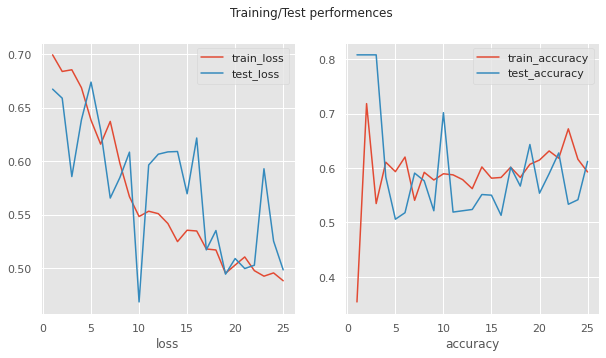

In [ ]:
dict_classification_history = classification_history.history
plot_history(dict_classification_history,classification_epochs)

**Testing the model for classification**

In [ ]:
classification_model_ = keras.models.load_model('./350_350_pretrained_distance_model.h5')

In [ ]:
ref_imgs = [path for path in glob.glob("./Dataset/damaged/*/*.png") if path not in meta_df_test["img_path"].values ]
ref_of_class = pd.DataFrame(ref_imgs,columns=["path"])
ref_of_class["anomaly"] = ref_of_class["path"].apply(lambda x : x.split("/")[-2])
for anomaly_type in ref_of_class["anomaly"].unique() : 
    all_paths_anomaly = ref_of_class[ref_of_class["anomaly"]==anomaly_type]["path"].values
    anomaly_ref_npy = []
    for path in all_paths_anomaly :
        img_keras = load_img(path,target_size=(350,350))
        img_keras = img_to_array(img_keras)/255
        anomaly_ref_npy.append(img_keras)
    anomaly_ref_npy = np.array(anomaly_ref_npy)
    np.save("./Dataset/damaged/"+anomaly_type+"/merged_refs.npy",anomaly_ref_npy)

In [ ]:
def load_refs():
    
    all_ref = glob.glob("./Dataset/damaged/*/merged_refs.npy")
    ref_class_array = []
    for ref in all_ref:
        class_ref = ref.split("/")[-2]
        ref_array = np.load(ref)
        ref_class_array.append([class_ref,ref_array])
    
    return np.array(ref_class_array)


def test_img(pretrained_model, path_img, refs):
    
    distance_descisions = {}
    classes = ["different","same"]
    img_keras_test = load_img(path_img,target_size=(350,350))
    img_keras_test = img_to_array(img_keras_test)/255
    
    for cpt ,anomaly in enumerate(refs[:,0]) : 
        distance_descisions[anomaly] = []
        for img_ref_array in refs[cpt,1]:
            img_keras_to_feed = np.absolute(img_ref_array-img_keras_test).astype("float32")
            prob_decision = pretrained_model.predict(np.expand_dims(img_keras_to_feed, axis=0))
            decision_index = prob_decision.argmax(axis=-1)[0]
            distance_descisions[anomaly].append(classes[decision_index])
    
    final_decision = "good"
    percentage_decision = 0
    for anomaly in distance_descisions : 
        percentage =  np.where(np.array(distance_descisions[anomaly])=="same",1,0).sum()/len(distance_descisions[anomaly])
        if(percentage > percentage_decision):
            final_decision = anomaly
            percentage_decision = percentage
            
    return final_decision

In [ ]:
refrences = load_refs()
meta_df_test["pred_class"] = meta_df_test["img_path"].apply(lambda x : test_img(classification_model_, x, refrences) )
meta_df_test[meta_df_test["class"]!="good"]

,img_path,class,pred_class
0,./Dataset/damaged/bent/013.png,bent,good
1,./Dataset/damaged/flip/012.png,flip,flip
2,./Dataset/damaged/color/017.png,color,color
3,./Dataset/damaged/flip/009.png,flip,flip
4,./Dataset/damaged/scratch/005.png,scratch,scratch
5,./Dataset/damaged/flip/015.png,flip,flip
6,./Dataset/damaged/scratch/001.png,scratch,scratch
9,./Dataset/damaged/scratch/000.png,scratch,bent
10,./Dataset/damaged/color/006.png,color,scratch
11,./Dataset/damaged/flip/017.png,flip,flip


In [ ]:
1- meta_df_test[meta_df_test["class"]!=meta_df_test["pred_class"]].shape[0]/meta_df_test.shape[0]

0.6956521739130435

# **Image segmentation with an inception model architecture**

**Preparing the model**

Instead of a single convolution block an inception block is used to extract the features from the image.

In an inception block input is divided into multiple instances and passed to different combinations of convolution layer and then the output from all the combinations are concatenated and passed further.

An inception block extracts richer feature compared to a convolution layer since in an inception block same input feature is passed through different sized kernel of convolutions, which enables the model to process the features from different point of views.

Different combinations of layers can be experimented with. Also different inception blocks can be combined in a same model and used as done in the actual inception model.

In [ ]:
import skimage 
# Load the training files
X = []
file_train = "./Dataset/damaged_annotated/*/*.png"
file_train = glob.glob(file_train)
for i, file in enumerate(file_train):
        im = skimage.io.imread(file)
        im = skimage.transform.resize(im,(512,512,3))
        X.append(im)
X = np.array(X)



## change new_crop_blunt_mask file to point to the file where new training masks are present.
file_mask = glob.glob("./Dataset/annotations/*/*.png")
y = []
for i in file_mask:
        im = skimage.io.imread(i)
        im = skimage.transform.resize(im,(512,512,1))
        y.append(im)  
y = np.array(y)

**Auto Encoder with U-Net Architecture**

In [ ]:
def keras_model(img_width=512, img_height=512):

    inputs = Input((img_width, img_height, 3))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
    model.summary()
    
    return model 

In [ ]:

model = keras_model(img_width=512, img_height=512)


Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 512, 512, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_341 (Conv2D)             (None, 512, 512, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_161 (Dropout)           (None, 512, 512, 16) 0           conv2d_341[0][0]                 
______________________________________________________________________________________

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,np.round(y).astype(int), test_size=0.1, random_state=3)

In [ ]:
nb_epoch = 15
# Train model
model.fit(x=x_train, y=y_train, steps_per_epoch=10, epochs=nb_epoch, verbose=1)

Epoch 1/15
10/10 [==============================] - 3s 287ms/step - loss: 0.5940 - accuracy: 0.7057
Epoch 2/15
10/10 [==============================] - 2s 213ms/step - loss: 0.4673 - accuracy: 0.8398
Epoch 3/15
10/10 [==============================] - 2s 213ms/step - loss: 0.4584 - accuracy: 0.8347
Epoch 4/15
10/10 [==============================] - 2s 214ms/step - loss: 0.4783 - accuracy: 0.8347
Epoch 5/15
10/10 [==============================] - 2s 214ms/step - loss: 0.4553 - accuracy: 0.8406
Epoch 6/15
10/10 [==============================] - 2s 214ms/step - loss: 0.4544 - accuracy: 0.8406
Epoch 7/15
10/10 [==============================] - 2s 215ms/step - loss: 0.4497 - accuracy: 0.8406
Epoch 8/15
10/10 [==============================] - 2s 215ms/step - loss: 0.4418 - accuracy: 0.8406
Epoch 9/15
10/10 [==============================] - 2s 215ms/step - loss: 0.4401 - accuracy: 0.8406
Epoch 10/15
10/10 [==============================] - 2s 215ms/step - loss: 0.4367 - accuracy: 0.8406

In [ ]:
pred = model.predict(x_test)

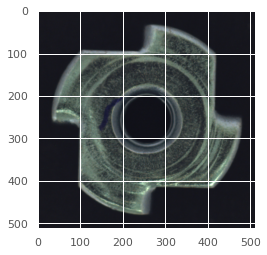

In [ ]:
plt.imshow(x_test[0])

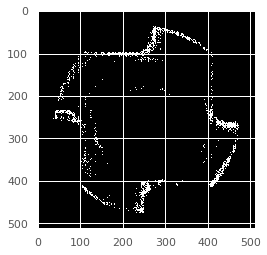

In [ ]:
plt.imshow(np.squeeze(np.round(pred[0]).astype(int)), cmap='gray',  interpolation='nearest')